In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [3]:
!pip install sklearn

Looking in indexes: https://repo.forge.lmig.com/api/pypi/python/simple
     |████████████████████████████████| 24.7 MB 62.9 MB/s eta 0:00:01
     |████████████████████████████████| 306 kB 60.9 MB/s eta 0:00:01
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1317 sha256=b8c9ee505ca34a85c6eb55973ee03c025971b51cd293e5777eeec9310e111229
  Stored in directory: /mnt/N0368582/.cache/pip/wheels/e9/1f/b4/bd738a33bbb1e417a9f794405f7d78d2f80c54b8c599a0d3ef
Successfully built sklearn


In [4]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, auc, roc_curve, f1_score
import dask_ml as dml
import dask_ml.model_selection as dcv
from dask.diagnostics import ProgressBar

import warnings
warnings.simplefilter('always', category=UserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

In [16]:
df = pd.read_csv('clean_merged_data.csv')
del df['Unnamed: 0']
modeling_data = df[[
    'offer_id', 
    'offer_type',
    'duration',
    'offer_reward',
    'difficulty',
    'num_channels',
    'channel_email', 
    'channel_mobile', 
    'channel_social', 
    'channel_web',
    'gender', 
    'age',  
    'income',
    'membership_days',
    'membership_month', 
    'membership_year',
    'successful_offer'   
        ]]
df.head()

,person,offer_id,original_reward,time_received,duration,time_viewed,time_completed,expiray_time,successful_offer,tried_offer,...,membership_month,membership_year,channel_email,channel_mobile,channel_social,channel_web,difficulty,offer_type,offer_reward,num_channels
0,user_100,bogo_7_10,0.0,336.0,7.0,NaN,NaN,343.0,0,0,...,7.0,2016.0,1,1,1,0,10,bogo,10,3
1,user_100,discount_10_5,0.0,0.0,10.0,NaN,NaN,10.0,0,0,...,7.0,2016.0,1,0,0,1,20,discount,5,2
2,user_100,discount_10_5,0.0,576.0,10.0,NaN,NaN,586.0,0,0,...,7.0,2016.0,1,0,0,1,20,discount,5,2
3,user_100,informational_4,0.0,408.0,4.0,NaN,NaN,412.0,0,0,...,7.0,2016.0,1,1,0,1,0,informational,0,3
4,user_10002,informational_4,0.0,336.0,4.0,NaN,NaN,340.0,0,0,...,11.0,2015.0,1,1,0,1,0,informational,0,3


In [17]:
cont_vars = [
    'duration',
    'num_channels',
    'channel_email', 
    'channel_mobile', 
    'channel_social', 
    'channel_web',
    'age',  
    'income',
    'membership_days'
]

cat_vars = [
    'offer_id',
    'offer_type',
    'offer_reward',
    'difficulty',
    'gender', 
    'membership_month', 
    'membership_year'
]

features = cont_vars+cat_vars

y_var = 'successful_offer'

In [18]:
for i in cat_vars:
    modeling_data.loc[:, i] = modeling_data[i].astype('category')

/opt/cortex-installs/miniconda/envs/cortex-python3/lib/python3.9/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [19]:
features

['duration',
 'num_channels',
 'channel_email',
 'channel_mobile',
 'channel_social',
 'channel_web',
 'age',
 'income',
 'membership_days',
 'offer_id',
 'offer_type',
 'offer_reward',
 'difficulty',
 'gender',
 'membership_month',
 'membership_year']

In [22]:
from sklearn.model_selection import train_test_split
import lightgbm as lgb


In [23]:
Y = modeling_data[y_var].astype(str)
train_val_df, test_df = train_test_split(modeling_data, test_size=0.2, random_state=2021, stratify = Y)
Y = train_val_df[y_var].astype(str)
train_df, val_df = train_test_split(train_val_df, test_size=0.2, random_state=2021, stratify = Y)


train_data = lgb.Dataset(train_df[features], label=train_df[y_var],free_raw_data=False)
val_data = lgb.Dataset(val_df[features], label=val_df[y_var],free_raw_data=False)
test_data = lgb.Dataset(test_df[features], label=test_df[y_var], free_raw_data=False)


scale_pos_weight_val = (len(train_df)-sum(train_df[y_var]))/sum(train_df[y_var])
print(scale_pos_weight_val)
(len(test_df)-sum(test_df[y_var]))/sum(test_df[y_var])

37.538128249566725


37.608333333333334

In [24]:
import itertools
def plot_confusion_matrix(cm, cmap=plt.cm.BuGn):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    title='Confusion matrix'
    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize = 15)
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks([-0.5,1.5], [0,1], rotation=0)
#     plt.yticks(tick_marks, [0,1])

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label', fontsize = 15)
    plt.xlabel('Predicted label', fontsize = 15)

In [25]:
def perf_analysis(model, data, features, y_var, which_data = 'Train Set'):
    print('**************', 'Performance:', which_data, '****************', '\n')
    
    
    y_pred = model.predict(data[features])
    y_pred = y_pred.round(0)
    cnf_matrix = confusion_matrix(data[y_var], y_pred)
    plot_confusion_matrix(cnf_matrix)

    
    print("Accuracy:", round(accuracy_score(data[y_var], y_pred),2))
    print("Precision:", round(precision_score(data[y_var], y_pred),2))
    print("Recall:", round(recall_score(data[y_var], y_pred),2))
    print("F1:", round(f1_score(data[y_var], y_pred),2))

#     fpr, tpr, thresholds = roc_curve(data[y_var], model.predict_proba(data[features])[:, 1])
    
    fpr, tpr, thresholds = roc_curve(data[y_var], model.predict(data[features]))
    
    
    roc_auc = auc(fpr,tpr)

    # Plot ROC
    plt.figure(figsize = (8,6))
    plt.title(which_data+': ROC', fontsize = 15)
    plt.plot(fpr, tpr, 'b',label='AUC = %0.3f'% roc_auc)
    plt.legend(loc='lower right', fontsize =15)
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([-0.1,1.0])
    plt.ylim([-0.1,1.01])
    plt.ylabel('True Positive Rate', fontsize = 15)
    plt.xlabel('False Positive Rate', fontsize = 15)
    plt.show()

In [26]:
# mc = [1 for f in cont_vars]+[None for f in cat_vars]


params = {'objective': "binary", 'metric': ['binary_logloss', 'binary_error'], 'num_threads':-1, 'seed':2021, 'verbose': -1,
              
              'max_depth':5, 
              'num_leaves':10, 
              'learning_rate': 0.2,
              'num_iterations':1000,
              'min_data_in_leaf': 300,
              'max_bin':100,
          'scale_pos_weight':scale_pos_weight_val
#          'monotone_constraints': mc
         }

gbm_model = lgb.train(params,
            train_data,
            valid_sets=[val_data],
            feature_name=features,
            categorical_feature=cat_vars,
            verbose_eval=-1,
            early_stopping_rounds=400, )

/opt/cortex-installs/miniconda/envs/cortex-python3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/cortex-installs/miniconda/envs/cortex-python3/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/cortex-installs/miniconda/envs/cortex-python3/lib/python3.9/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['difficulty', 'gender', 'membership_month', 'membership_year', 'offer_id', 'offer_reward', 'offer_type']
  _log_warning('categorical_feature in Datas

Training until validation scores don't improve for 400 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's binary_logloss: 0.306056	valid_0's binary_error: 0.130767


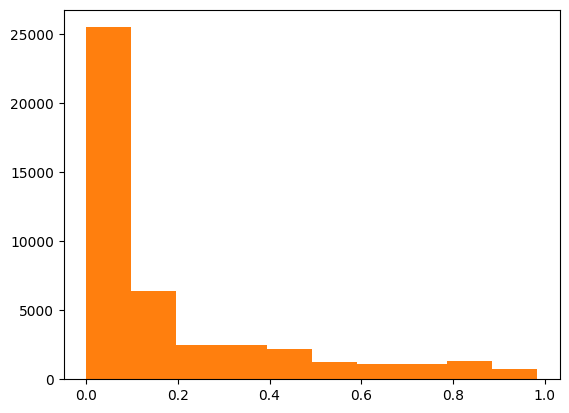

In [30]:
y_preds = gbm_model.predict(train_df[features])
plt.hist(y_preds)
plt.show()

************** Performance: Train Set **************** 

Accuracy: 0.9
Precision: 0.21
Recall: 0.97
F1: 0.34


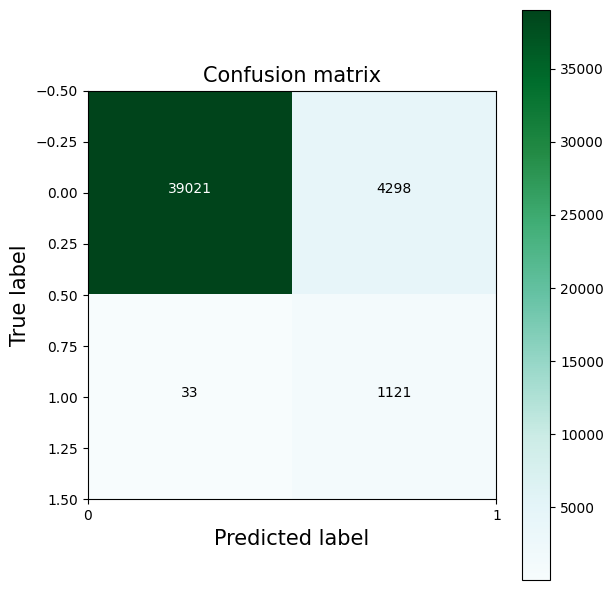

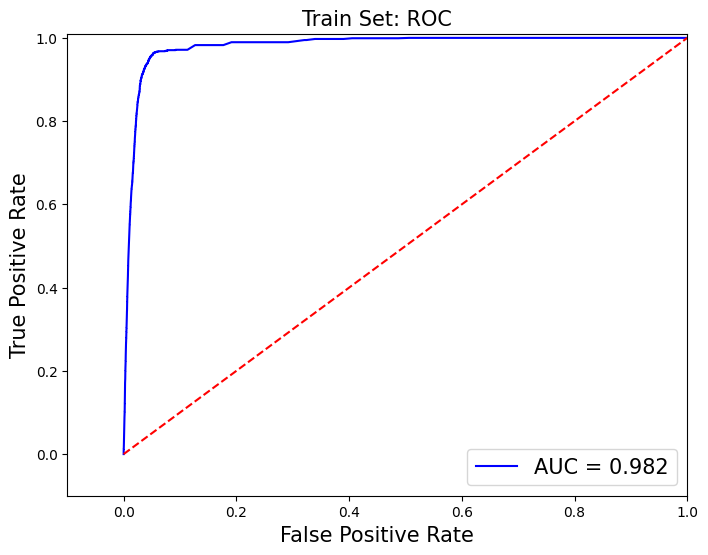

************** Performance: Test Set **************** 

Accuracy: 0.87
Precision: 0.07
Recall: 0.29
F1: 0.11


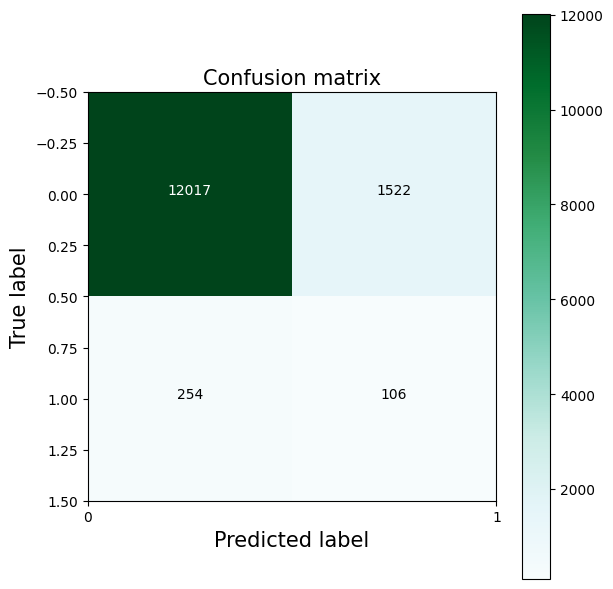

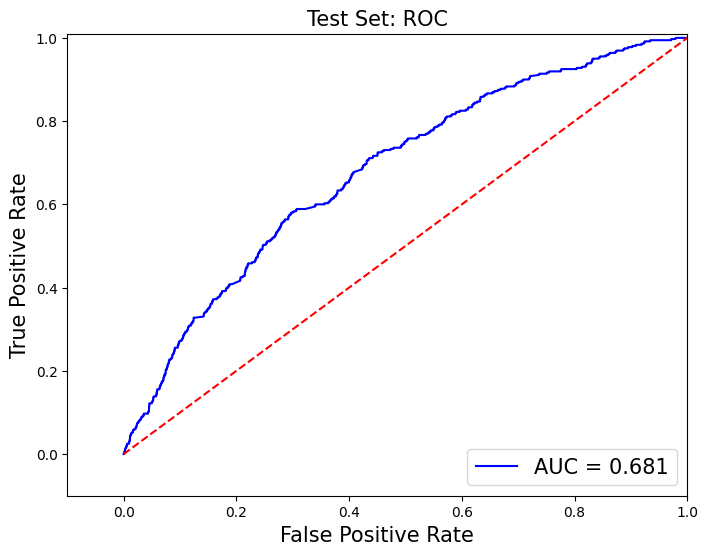

In [31]:
perf_analysis(model = gbm_model, data = train_df, features = features, y_var = y_var, which_data = 'Train Set')
perf_analysis(model = gbm_model, data = test_df, features = features, y_var = y_var, which_data = 'Test Set')

In [32]:
Y = modeling_data[y_var].astype(str)
train_df, test_df = train_test_split(modeling_data, test_size=0.2, random_state=2021, stratify = Y)


scale_pos_weight_val = (len(train_df)-sum(train_df[y_var]))/sum(train_df[y_var])
print(scale_pos_weight_val)
(len(test_df)-sum(test_df[y_var]))/sum(test_df[y_var])

37.552011095700415


37.608333333333334

In [33]:
param_test ={'max_depth':[3,5,8,10],
    'num_leaves': [5,10,20, 30, 40], 
             'min_child_samples': [200, 400], 
             'reg_alpha': [0, 1e-2, 1e-1, 1],
             'reg_lambda': [0, 1e-2, 1e-1, 1],
             'scale_pos_weight': [scale_pos_weight_val]
            }

In [39]:
gbm_model = lgb.LGBMClassifier(objective = "binary", metric = ['auc', 'binary_error'], random_state=2021, verbose=-1, n_jobs=-1, n_estimators=1000)
gbm_gs = dcv.GridSearchCV(
    estimator=gbm_model, param_grid=param_test, 
    scoring='f1',
    cv=5,
    refit=True,
)

In [40]:
with ProgressBar():
    gbm_gs.fit(train_df[features], train_df[y_var])

[########################################] | 100% Completed |  4hr 55min 39.7s
[########################################] | 100% Completed |  1min 20.4s
